# 🌸 CNN-only Flower Classifier

This notebook focuses solely on a custom CNN model with:
- Preprocessing and dataset inspection
- Visualizations and augmentation
- CNN definition, training with callbacks and class weights
- Validation evaluation (report + confusion matrix)
- Test-time inference using `archive_2/Testing_set_flower.csv`
- Saving submissions as `cnn_flower_submission.csv` and `flower_submission_corrected.csv`


In [18]:
# 1) Import Libraries and Set Seeds
import os
import json
import math
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

print(f"TensorFlow: {tf.__version__}")
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Optional: enable GPU memory growth if GPU is present
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs detected and memory growth enabled: {len(gpus)}")
    else:
        print("No GPU detected, using CPU")
except Exception as e:
    print("GPU setup note:", e)

TensorFlow: 2.20.0
No GPU detected, using CPU


In [2]:
import tensorflow as tf

try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPUs detected and memory growth enabled: {len(gpus)}")
    else:
        print("❌ No GPU detected, using CPU")
except Exception as e:
    print("GPU setup note:", e)

# Expected output if successful:
# ✅ GPUs detected and memory growth enabled: 1

❌ No GPU detected, using CPU


In [3]:
# 2) Configuration and Paths
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
EPOCHS = 25
LEARNING_RATE = 1e-4
VALIDATION_SPLIT = 0.2
SEED = 42

# Paths relative to this repo root
TRAIN_DIR = "archive_2/train"
TEST_DIR = "archive_2/test"
TEST_CSV = "archive_2/Testing_set_flower.csv"
SAMPLE_SUB = "archive_2/sample_submission.csv"
MODELS_DIR = "models"
Path(MODELS_DIR).mkdir(parents=True, exist_ok=True)

print({
    'BATCH_SIZE': BATCH_SIZE,
    'IMG_SIZE': IMG_SIZE,
    'EPOCHS': EPOCHS,
    'LEARNING_RATE': LEARNING_RATE,
    'VALIDATION_SPLIT': VALIDATION_SPLIT,
    'TRAIN_DIR': TRAIN_DIR,
    'TEST_DIR': TEST_DIR
})

{'BATCH_SIZE': 32, 'IMG_SIZE': (224, 224), 'EPOCHS': 25, 'LEARNING_RATE': 0.0001, 'VALIDATION_SPLIT': 0.2, 'TRAIN_DIR': 'archive_2/train', 'TEST_DIR': 'archive_2/test'}


Classes: 5 | Total images: 2746 | Imbalance ratio: 1.31
- daisy: 501
- dandelion: 646
- rose: 497
- sunflower: 495
- tulip: 607


C:\Users\Ammad\AppData\Local\Temp\ipykernel_19044\2760099283.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette='viridis')


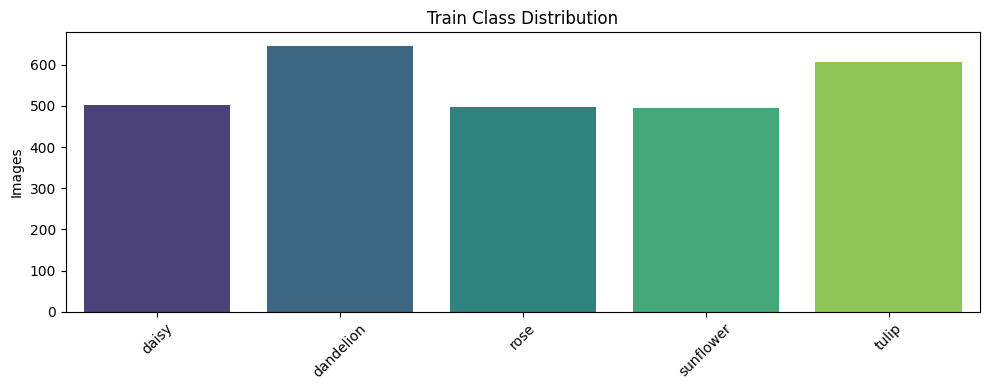

In [4]:
# 3) Inspect Dataset and Class Distribution (Train)
from collections import defaultdict

class_counts = {}
for class_name in sorted(os.listdir(TRAIN_DIR)):
    class_path = os.path.join(TRAIN_DIR, class_name)
    if os.path.isdir(class_path):
        count = len([f for f in os.listdir(class_path) if f.lower().endswith(('jpg','jpeg','png'))])
        class_counts[class_name] = count

if not class_counts:
    raise RuntimeError(f"No class folders found in {TRAIN_DIR}. Ensure train data is in subfolders per class.")

classes = list(class_counts.keys())
counts = np.array([class_counts[c] for c in classes])
imbalance_ratio = counts.max() / max(1, counts.min())

print(f"Classes: {len(classes)} | Total images: {counts.sum()} | Imbalance ratio: {imbalance_ratio:.2f}")
for c in classes:
    print(f"- {c}: {class_counts[c]}")

# Bar plot
plt.figure(figsize=(10,4))
sns.barplot(x=classes, y=counts, palette='viridis')
plt.title('Train Class Distribution')
plt.ylabel('Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
# 4) Compute Class Weights
# Compute directly from generator-compatible indices for correct alignment
# (Runs after data inspection to know available classes; will be updated after generators too if needed)
from sklearn.utils.class_weight import compute_class_weight

# If you want to compute pre-generator, keep this version using class_counts
class_to_index = {c:i for i,c in enumerate(classes)}
indices = []
for c, n in class_counts.items():
    indices.extend([class_to_index[c]] * n)
indices = np.array(indices)
weights_arr = compute_class_weight(class_weight='balanced', classes=np.arange(len(classes)), y=indices)
class_weights_pre = {i: float(weights_arr[i]) for i in range(len(classes))}
print("Initial class weights (by counts):", {classes[i]: round(class_weights_pre[i],3) for i in range(len(classes))})

Initial class weights (by counts): {'daisy': 1.096, 'dandelion': 0.85, 'rose': 1.105, 'sunflower': 1.109, 'tulip': 0.905}


In [6]:
# 5) Data Augmentation (ImageDataGenerator)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.10,
    zoom_range=0.20,
    brightness_range=[0.85, 1.15],
    channel_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=VALIDATION_SPLIT)

# 6) Build Train/Validation Datasets
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED,
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED,
    shuffle=False
)

class_indices = train_gen.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
print("Class indices:", class_indices)
print("Class names:", class_names)
print(f"Train samples: {train_gen.samples} | Val samples: {val_gen.samples}")

Found 2198 images belonging to 5 classes.
Found 548 images belonging to 5 classes.
Class indices: {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
Class names: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Train samples: 2198 | Val samples: 548
Found 548 images belonging to 5 classes.
Class indices: {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
Class names: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Train samples: 2198 | Val samples: 548


In [7]:
# 6.1) Recompute Class Weights using train_gen.classes (index-aligned)
from sklearn.utils.class_weight import compute_class_weight
cls_indices, cls_counts = np.unique(train_gen.classes, return_counts=True)
weights_arr = compute_class_weight(class_weight='balanced', classes=cls_indices, y=train_gen.classes)
class_weights = {int(c): float(w) for c, w in zip(cls_indices, weights_arr)}
print('Class weights (aligned):', {list(train_gen.class_indices.keys())[int(c)]: round(class_weights[int(c)],3) for c in cls_indices})

Class weights (aligned): {'daisy': 1.096, 'dandelion': 0.85, 'rose': 1.105, 'sunflower': 1.11, 'tulip': 0.905}


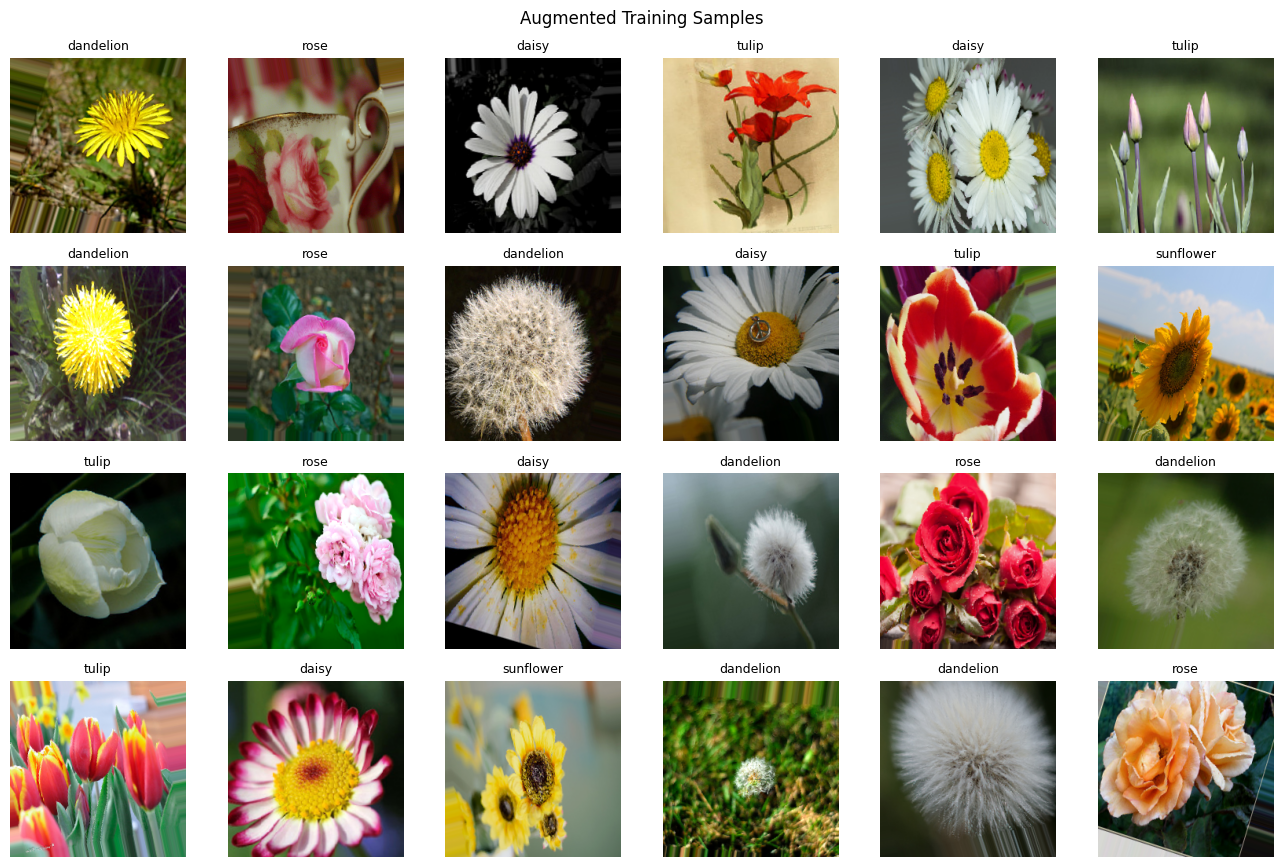

In [8]:
# 7) Visualize Augmented Samples
images, labels = next(train_gen)
rows, cols = 4, 6
plt.figure(figsize=(cols*2.2, rows*2.2))
for i in range(rows*cols):
    if i >= len(images):
        break
    ax = plt.subplot(rows, cols, i+1)
    plt.imshow(images[i])
    cls_idx = np.argmax(labels[i])
    plt.title(idx_to_class.get(cls_idx, str(cls_idx)), fontsize=9)
    plt.axis("off")
plt.suptitle("Augmented Training Samples")
plt.tight_layout()
plt.show()

In [9]:
# 8) Define Enhanced CNN Architecture
def build_cnn(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=len(class_names)):
    L2 = keras.regularizers.l2(1e-4)
    model = keras.Sequential([
        layers.Input(shape=input_shape),

        # Block 1
        layers.Conv2D(32, 3, padding='same', use_bias=False, kernel_regularizer=L2),
        layers.BatchNormalization(), layers.Activation('relu'),
        layers.Conv2D(32, 3, padding='same', use_bias=False, kernel_regularizer=L2),
        layers.BatchNormalization(), layers.Activation('relu'),
        layers.MaxPooling2D(2),
        layers.Dropout(0.20),

        # Block 2
        layers.Conv2D(64, 3, padding='same', use_bias=False, kernel_regularizer=L2),
        layers.BatchNormalization(), layers.Activation('relu'),
        layers.Conv2D(64, 3, padding='same', use_bias=False, kernel_regularizer=L2),
        layers.BatchNormalization(), layers.Activation('relu'),
        layers.MaxPooling2D(2),
        layers.Dropout(0.30),

        # Block 3
        layers.Conv2D(128, 3, padding='same', use_bias=False, kernel_regularizer=L2),
        layers.BatchNormalization(), layers.Activation('relu'),
        layers.Conv2D(128, 3, padding='same', use_bias=False, kernel_regularizer=L2),
        layers.BatchNormalization(), layers.Activation('relu'),
        layers.MaxPooling2D(2),
        layers.Dropout(0.40),

        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu', kernel_regularizer=L2),
        layers.Dropout(0.40),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

cnn_model = build_cnn()
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 56, 56, 128)    │             

 Total params: 322,661 (1.23 MB)

 Trainable params: 321,765 (1.23 MB)

 Non-trainable params: 896 (3.50 KB)

In [10]:
# 9) Compile CNN Model
loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
cnn_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_acc')]
)

In [11]:
# 10) Train CNN with Callbacks and Class Weights
checkpoint_path = os.path.join(MODELS_DIR, 'cnn_best.keras')
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
]

history = cnn_model.fit(
    train_gen,
    epochs=max(EPOCHS, 35),
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1,
)

print('Training complete. Best model saved at:', checkpoint_path)

c:\Users\Ammad\Documents\Projects\Personal\UEL\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3423 - loss: 1.5879 - top3_acc: 0.7560
Epoch 1: val_loss improved from None to 1.67985, saving model to models\cnn_best.keras

Epoch 1: val_loss improved from None to 1.67985, saving model to models\cnn_best.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.4072 - loss: 1.4772 - top3_acc: 0.8226 - val_accuracy: 0.2354 - val_loss: 1.6799 - val_top3_acc: 0.5985 - learning_rate: 1.0000e-04
Epoch 2/35
69/69 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.4072 - loss: 1.4772 - top3_acc: 0.8226 - val_accuracy: 0.2354 - val_loss: 1.6799 - val_top3_acc: 0.5985 - learning_rate: 1.0000e-04
Epoch 2/35
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5107 - loss: 1.3578 - top3_acc: 0.8866
Epoch 2: val_loss did not improve from 1.67985
69/69 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.5055 - loss: 1.3483 - top3_acc: 0.8872 - val_accuracy: 0.2354 - val_loss: 1.8106 - val_top3_acc: 0.5985 - learning_rate: 1.0000e-04
Epoch

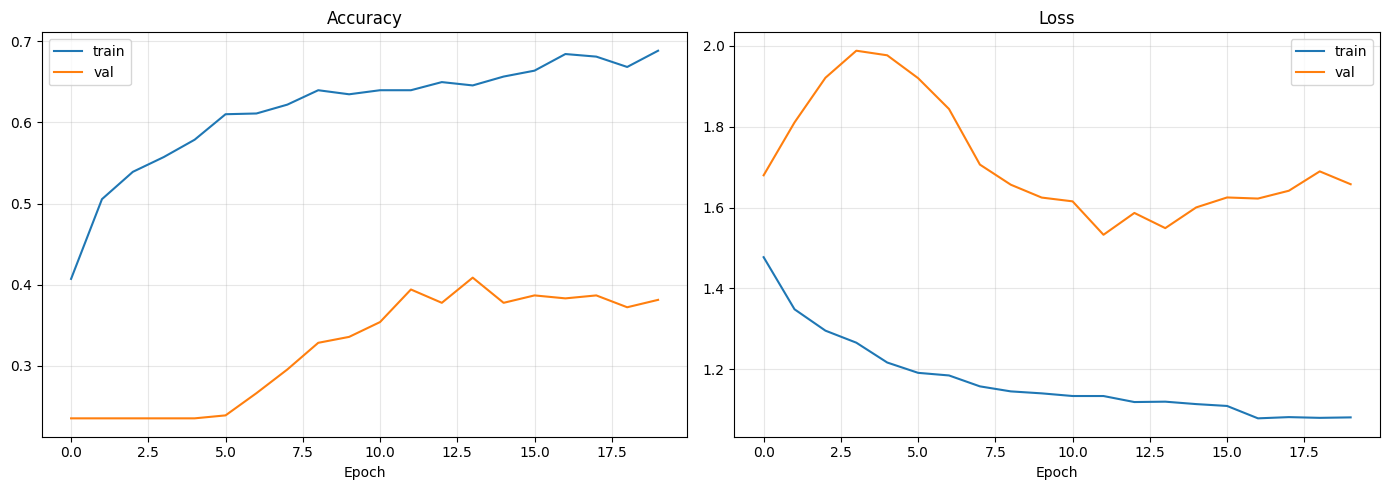

In [12]:
# 11) Plot Training Curves
fig, axes = plt.subplots(1, 2, figsize=(14,5))
axes[0].plot(history.history['accuracy'], label='train')
axes[0].plot(history.history['val_accuracy'], label='val')
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], label='train')
axes[1].plot(history.history['val_loss'], label='val')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 411ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 411ms/step
Validation Accuracy: 0.39416058394160586

Classification Report:
              precision    recall  f1-score   support

       daisy       0.88      0.15      0.26       100
   dandelion       0.30      1.00      0.46       129
        rose       0.58      0.30      0.40        99
   sunflower       0.91      0.21      0.34        99
       tulip       0.81      0.17      0.29       121

    accuracy                           0.39       548
   macro avg       0.70      0.37      0.35       548
weighted avg       0.68      0.39      0.35       548

Validation Accuracy: 0.39416058394160586

Classification Report:
              precision    recall  f1-score   support

       daisy       0.88      0.15      0.26       100
   dandelion       0.30      1.00      0.46       129
        rose       0.58      0.30      0.40        99
   sunflower       0.91      0.21      0.34        99
       tulip       0.81     

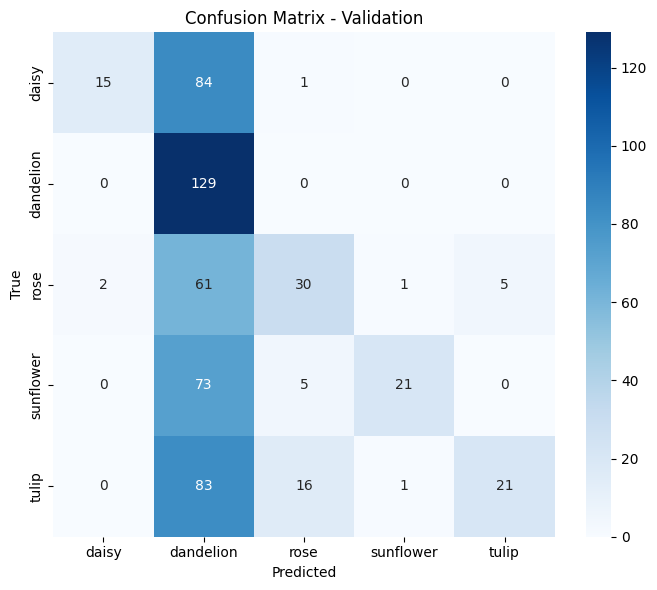

In [13]:
# 12) Validation Evaluation: Classification Report & Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix

# Reset and predict on validation generator
val_gen.reset()
val_steps = int(np.ceil(val_gen.samples / val_gen.batch_size))
val_probs = cnn_model.predict(val_gen, steps=val_steps, verbose=1)
val_pred_idx = np.argmax(val_probs, axis=1)
val_true_idx = val_gen.classes

# Ensure class_names are ordered by index for correct reporting
class_names = [name for name, idx in sorted(train_gen.class_indices.items(), key=lambda kv: kv[1])]

print('Validation Accuracy:', np.mean(val_pred_idx == val_true_idx))
print('\nClassification Report:')
print(classification_report(val_true_idx, val_pred_idx, target_names=class_names))

cm = confusion_matrix(val_true_idx, val_pred_idx)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Validation')
plt.tight_layout()
plt.show()

In [14]:
# 13) Build Test Pipeline and Predict
# Load best model if checkpoint exists
checkpoint_path = os.path.join(MODELS_DIR, 'cnn_best.keras')
if os.path.exists(checkpoint_path):
    best_model = tf.keras.models.load_model(checkpoint_path)
    print(f'Loaded best model from: {checkpoint_path}')
else:
    best_model = cnn_model
    print('Best checkpoint not found; using current in-memory model.')

# Read test filenames from CSV
df_test = pd.read_csv(TEST_CSV)
assert 'filename' in df_test.columns, 'Testing_set_flower.csv must contain a column named filename'

test_files = df_test['filename'].tolist()

def load_and_preprocess(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img

# Build tf.data for test
full_paths = [os.path.join(TEST_DIR, f) for f in test_files]

test_ds = tf.data.Dataset.from_tensor_slices(full_paths)
test_ds = test_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Predict
test_probs = best_model.predict(test_ds, verbose=1)
test_pred_idx = np.argmax(test_probs, axis=1)
label_map = {v: k for k, v in train_gen.class_indices.items()}
pred_labels = [label_map[i] for i in test_pred_idx]

Loaded best model from: models\cnn_best.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 427ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 427ms/step


Saved: outputs\cnn_flower_submission.csv
Saved: flower_submission_corrected.csv

Prediction counts by class:
label
daisy         36
dandelion    759
rose          77
sunflower      7
tulip         45
Name: count, dtype: int64


C:\Users\Ammad\AppData\Local\Temp\ipykernel_19044\3469107395.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index, y=vc.values, palette='viridis')


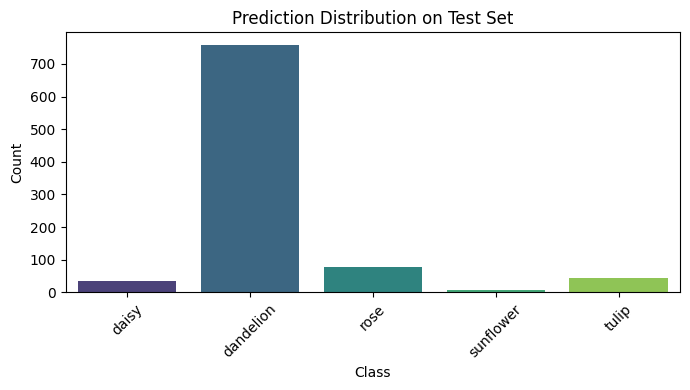

Imbalance ratio (max/min): 108.43


In [15]:
# 14) Save Submissions and Analyze Prediction Distribution
# Save two CSVs: filename,label and a single-column 'prediction'
outputs_dir = "outputs"
Path(outputs_dir).mkdir(parents=True, exist_ok=True)

sub_df = pd.DataFrame({
    'filename': df_test['filename'],
    'label': pred_labels
})

cnn_submission_csv = os.path.join(outputs_dir, 'cnn_flower_submission.csv')
sub_df.to_csv(cnn_submission_csv, index=False)
print('Saved:', cnn_submission_csv)

single_col_df = pd.DataFrame({'prediction': pred_labels})
corrected_csv = 'flower_submission_corrected.csv'
single_col_df.to_csv(corrected_csv, index=False)
print('Saved:', corrected_csv)

# Distribution analysis
vc = sub_df['label'].value_counts().sort_index()
print('\nPrediction counts by class:')
print(vc)

plt.figure(figsize=(7,4))
sns.barplot(x=vc.index, y=vc.values, palette='viridis')
plt.title('Prediction Distribution on Test Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Simple balance metric
p = vc.values / vc.values.sum()
imbalance_ratio = p.max() / p.min()
print(f'Imbalance ratio (max/min): {imbalance_ratio:.2f}')

In [16]:
# 15) Utility: Reload Best Model & Single-Image Inference

def load_best_model():
    path = os.path.join("outputs", "models", "cnn_best.keras")
    if os.path.exists(path):
        print('Loading best model from', path)
        return tf.keras.models.load_model(path)
    print('Best model not found; returning current model in memory')
    return cnn_model

best_model = load_best_model()

from PIL import Image

def predict_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(IMG_SIZE)
    arr = np.asarray(img) / 255.0
    arr = np.expand_dims(arr, axis=0)
    probs = best_model.predict(arr)
    idx = np.argmax(probs, axis=1)[0]
    label = label_map[idx]
    return label, probs[0]

# Example (optional):
# test_example = os.path.join(TEST_DIR, df_test['filename'].iloc[0])
# lbl, pr = predict_image(test_example)
# print('Predicted:', lbl)

Best model not found; returning current model in memory


## ✅ Wrap-up and How to Run

- Train: Run the notebook top-to-bottom. The best CNN checkpoint saves to `models/cnn_best.keras`.
- Validate: See training curves, accuracy, classification report, and confusion matrix on the validation split.
- Predict Test: The notebook reads `archive_2/Testing_set_flower.csv` and predicts on images in `archive_2/test`.
- Submissions:
  - `cnn_flower_submission.csv` is saved in `outputs/` with columns `filename,label`.
  - `flower_submission_corrected.csv` is saved at project root with single column `prediction`.
- Utilities: Use `predict_image(<path>)` to run inference on a single image.

If paths differ, update the BASE_DIR/TRAIN_DIR/TEST_DIR constants accordingly.

In [17]:
# 6.1) Recompute Class Weights using train_gen.classes (index-aligned)
cls_indices, cls_counts = np.unique(train_gen.classes, return_counts=True)
weights_arr = compute_class_weight(class_weight='balanced', classes=cls_indices, y=train_gen.classes)
class_weights = {int(c): float(w) for c, w in zip(cls_indices, weights_arr)}
print('Class weights (aligned):', {class_names[int(c)]: round(class_weights[int(c)],3) for c in cls_indices})

Class weights (aligned): {'daisy': 1.096, 'dandelion': 0.85, 'rose': 1.105, 'sunflower': 1.11, 'tulip': 0.905}
